# Alpaca Hum Segmentation – Benchmark Insights

**Notebook goal** – Load `metrics.csv` produced by `evaluate_benchmark.py`,
visualise and compare model variants across thresholds:

* Overall leaderboard (F1, precision, recall)
* F1 vs. classification threshold curves for each model
* Precision–Recall scatter
* Boundary‐error (Δstart/Δend) distribution
* Call‐rate correlation (Pearson vs. Spearman)
* Q1‐only recall heat‑map

In [32]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_context("talk")

In [33]:
METRICS_CSV = Path("/Users/danie/repos/alpaca-segmentation/BENCHMARK_TRAINING_CORPUS/metrics.csv")  # adjust if saved elsewhere
assert METRICS_CSV.exists(), f"{METRICS_CSV} not found"

In [34]:
df = pd.read_csv(METRICS_CSV)

def parse_variant_tag(tag: str):
    """return seq_len (ms), hop (ms), threshold (float)"""
    m = re.match(r"len(\d+)_hop(\d+)_th(\d+)", tag)
    if not m:
        return None, None, None
    seq = int(m[1]) / 1000  # back to s
    hop = int(m[2]) / 1000
    th = int(m[3]) / 100
    return seq, hop, th

df[["seq_len_s", "hop_s", "threshold"]] = (
    df["variant"].apply(lambda t: pd.Series(parse_variant_tag(t)))
)

In [35]:
leader_cols = [
    "model",
    "variant",
    "precision",
    "recall",
    "f1",
    "mean_dstart_ms",
    "mean_dend_ms",
]
leader = df[leader_cols].sort_values("f1", ascending=False)
leader.head(20)

,model,variant,precision,recall,f1,mean_dstart_ms,mean_dend_ms
0,v3_tape_proportional,len500_hop050_th70,0.002683,0.002582,0.002632,193.500000,143.500000
18,v1_random,len500_hop050_th70,0.002091,0.001937,0.002011,367.666667,130.666667
8,v3_tape_proportional,len500_hop050_th60,0.001734,0.001937,0.001830,232.000000,95.666667
7,v3_tape_proportional,len500_hop050_th50,0.001555,0.001937,0.001725,482.000000,95.666667
1,v3_tape_proportional,len500_hop050_th40,0.001400,0.001937,0.001625,548.666667,95.666667
21,v1_random,len500_hop050_th30,0.001319,0.001937,0.001569,355.666667,65.666667
12,v2_quality,len500_hop050_th30,0.001313,0.001937,0.001565,217.000000,31.666667
11,v2_quality,len500_hop050_th90,0.001873,0.001291,0.001528,381.000000,48.000000
3,v3_tape_proportional,len500_hop050_th30,0.001234,0.001937,0.001507,548.666667,95.666667
4,v3_tape_proportional,len500_hop050_th80,0.001665,0.001291,0.001455,406.000000,173.000000


### Recall vs. threshold for each model

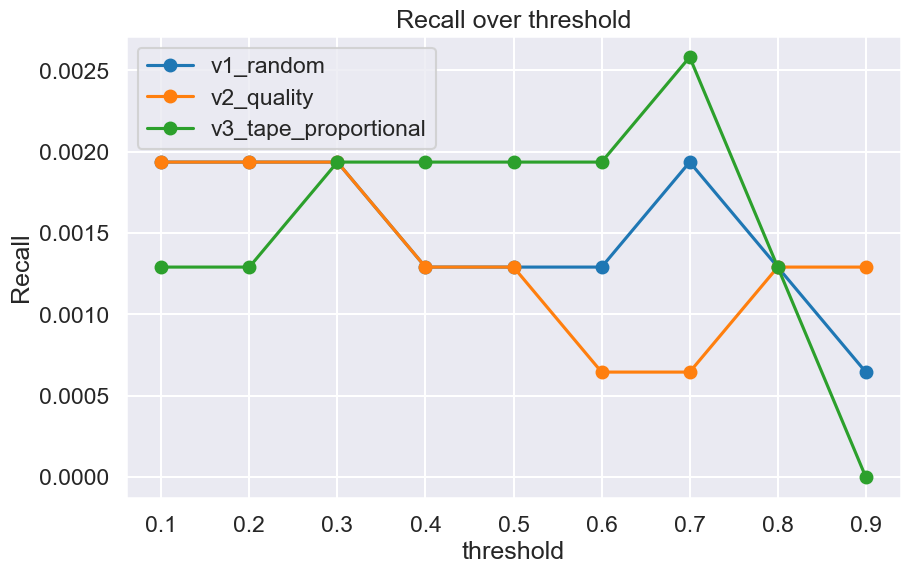

In [36]:
plt.figure(figsize=(10, 6))
for model, sub in df.groupby("model"):
    sub_sorted = sub.sort_values("threshold")
    plt.plot(sub_sorted["threshold"], sub_sorted["recall"], "-o", label=model)
plt.xlabel("threshold")
plt.ylabel("Recall")
plt.title("Recall over threshold")
plt.legend()
plt.grid(True)
plt.show()

## Recall vs. threshold for each quality (Q1–Q3)

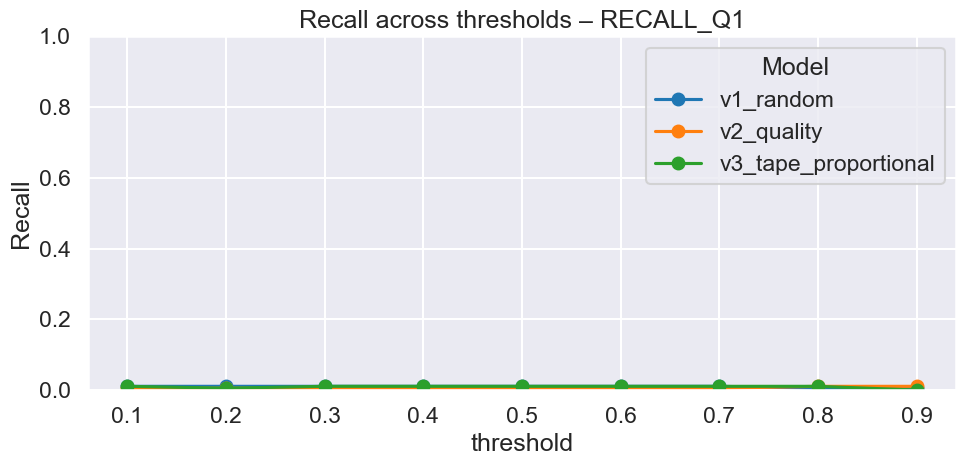

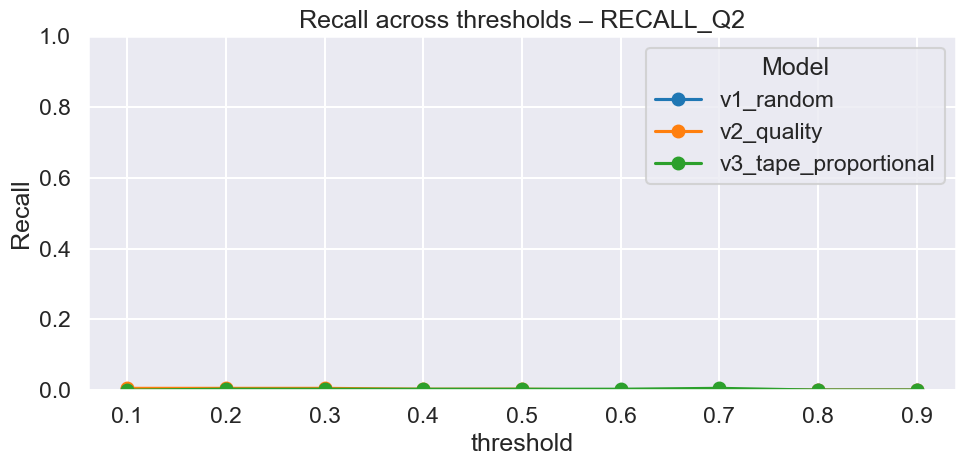

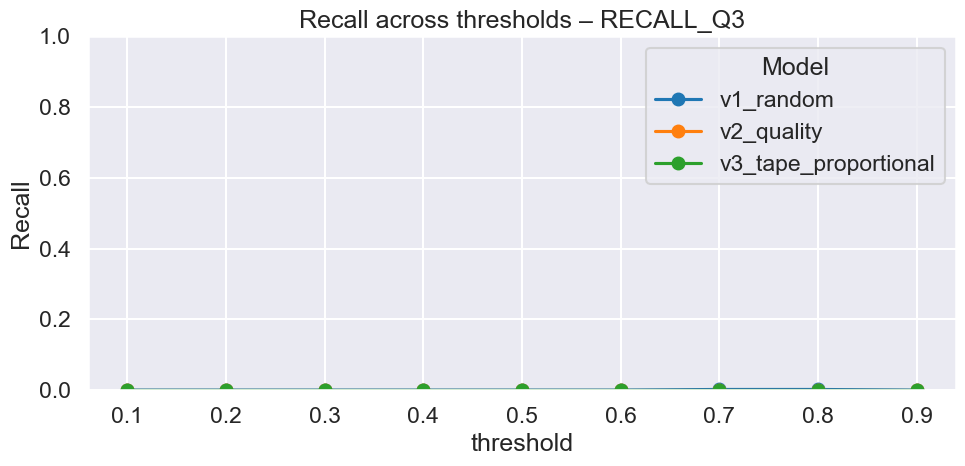

In [37]:
qualities = ["recall_q1", "recall_q2", "recall_q3"]

for q in qualities:
    if q in df.columns:
        plt.figure(figsize=(10, 5))
        for model, sub in df.groupby("model"):
            sub_sorted = sub.sort_values("threshold")
            plt.plot(
                sub_sorted["threshold"],
                sub_sorted[q],
                marker="o",
                label=model
            )
        plt.title(f"Recall across thresholds – {q.upper()}")
        plt.xlabel("threshold")
        plt.ylabel("Recall")
        plt.ylim(0, 1)
        plt.grid(True)
        plt.legend(title="Model")
        plt.tight_layout()
        plt.show()

### Detected calls vs. threshold (log scale)

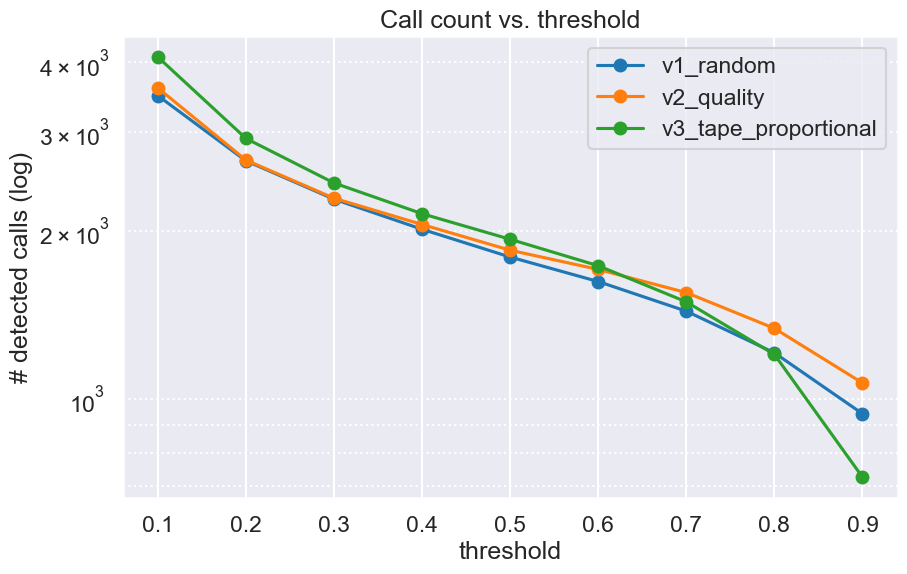

In [38]:
plt.figure(figsize=(10, 6))
for model, sub in df.groupby("model"):
    sub_sorted = sub.sort_values("threshold")
    plt.plot(sub_sorted["threshold"], sub_sorted["n_pred"], "-o", label=model)
plt.xlabel("threshold")
plt.ylabel("# detected calls (log)")
plt.yscale("log")
plt.title("Call count vs. threshold")
plt.legend()
plt.grid(True, which="both", axis="y", linestyle=":")
plt.show()

### Top‑5 variants by F1

In [39]:
leader.head(5).style.format({"precision": "{:.2%}", "recall": "{:.2%}", "f1": "{:.2%}"})

,model,variant,precision,recall,f1,mean_dstart_ms,mean_dend_ms
0,v3_tape_proportional,len500_hop050_th70,0.27%,0.26%,0.26%,193.500000,143.500000
18,v1_random,len500_hop050_th70,0.21%,0.19%,0.20%,367.666667,130.666667
8,v3_tape_proportional,len500_hop050_th60,0.17%,0.19%,0.18%,232.000000,95.666667
7,v3_tape_proportional,len500_hop050_th50,0.16%,0.19%,0.17%,482.000000,95.666667
1,v3_tape_proportional,len500_hop050_th40,0.14%,0.19%,0.16%,548.666667,95.666667


### F1 vs. threshold curve for each model

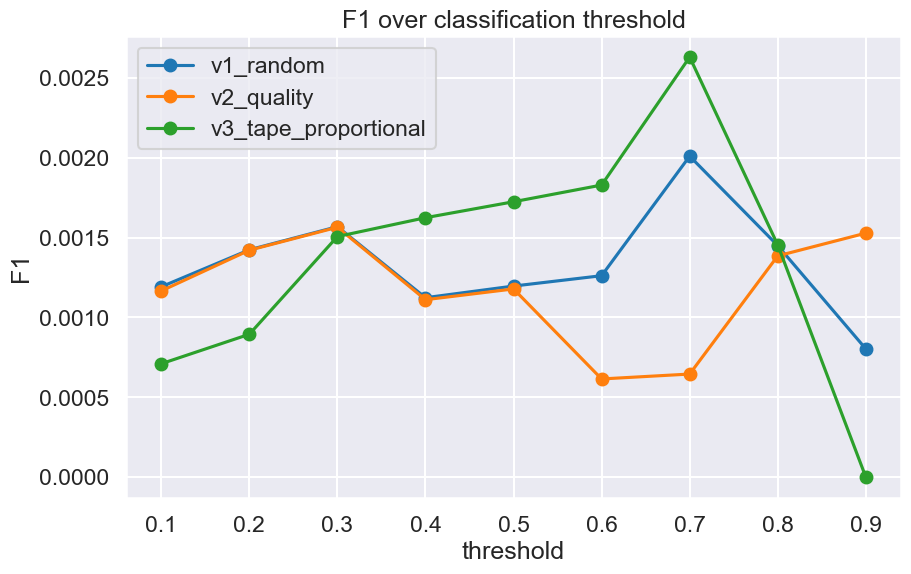

In [40]:
plt.figure(figsize=(10, 6))
for model, sub in df.groupby("model"):
    sub_sorted = sub.sort_values("threshold")
    plt.plot(sub_sorted["threshold"], sub_sorted["f1"], "-o", label=model)
plt.xlabel("threshold")
plt.ylabel("F1")
plt.title("F1 over classification threshold")
plt.legend()
plt.grid(True)
plt.show()

### F1 per quality level (Q1–Q3) across thresholds

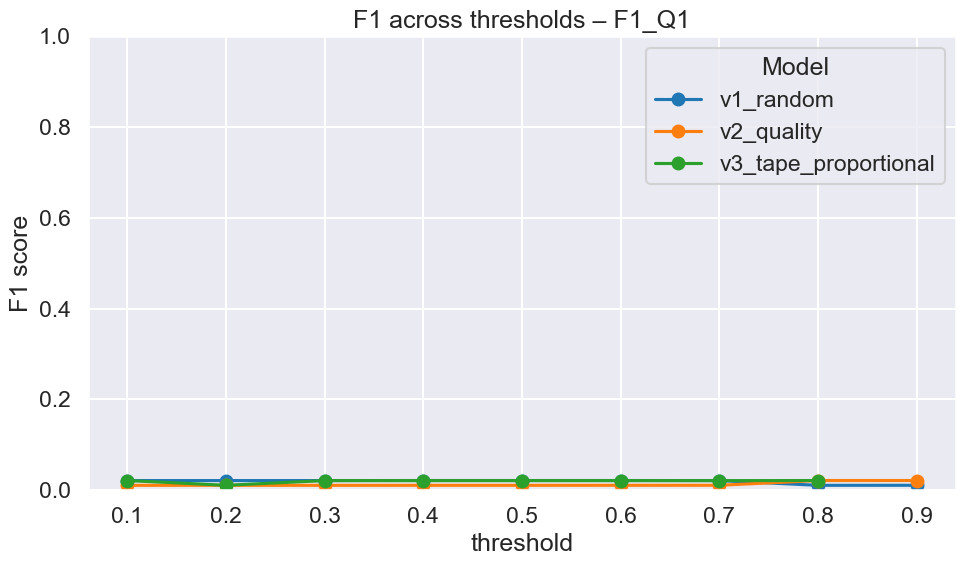

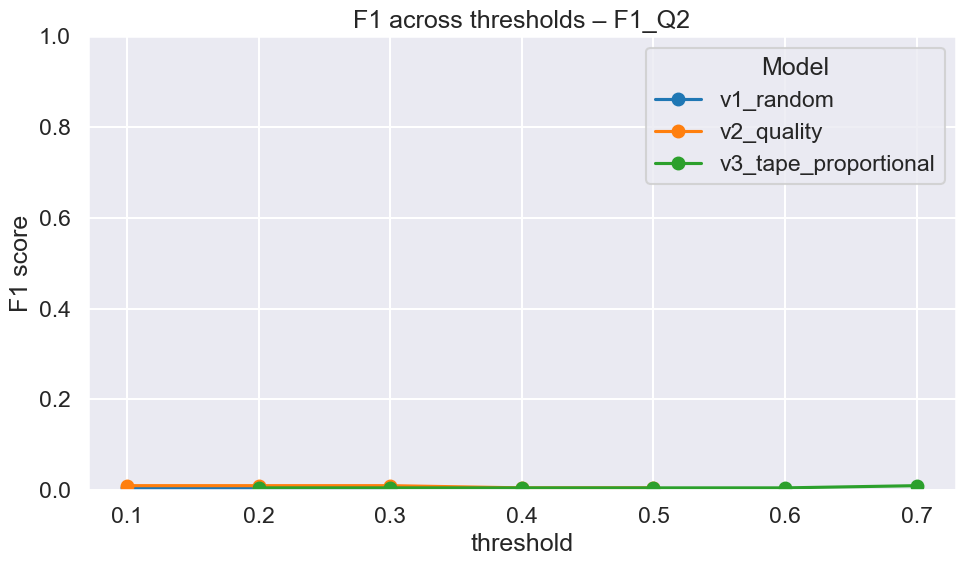

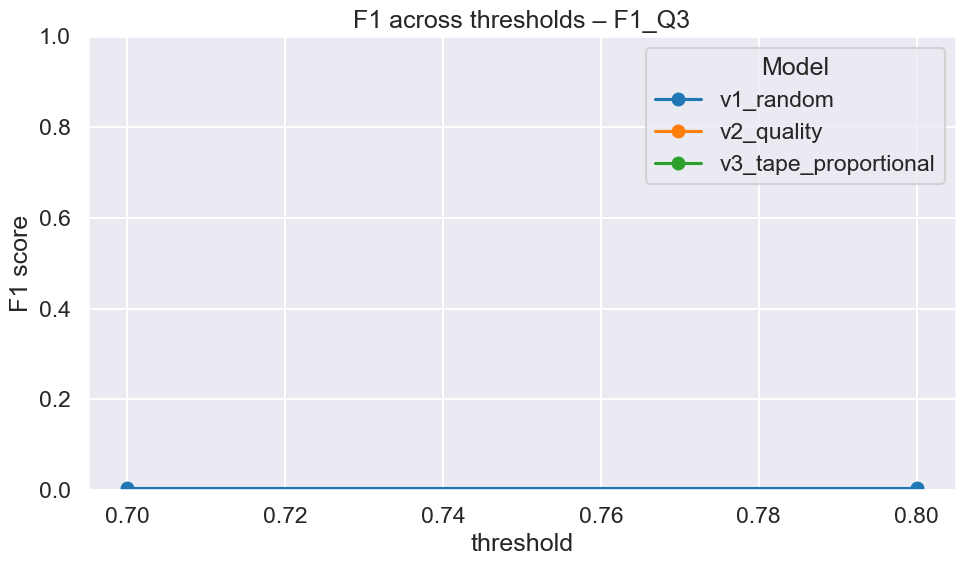

In [41]:
qualities = ["f1_q1", "f1_q2", "f1_q3"]

for q in qualities:
    if q in df.columns:
        plt.figure(figsize=(10, 6))
        for model, sub in df.groupby("model"):
            sub_sorted = sub.sort_values("threshold")
            plt.plot(
                sub_sorted["threshold"],
                sub_sorted[q],
                marker="o",
                label=model
            )
        plt.xlabel("threshold")
        plt.ylabel("F1 score")
        plt.title(f"F1 across thresholds – {q.upper()}")
        plt.ylim(0, 1)
        plt.grid(True)
        plt.legend(title="Model")
        plt.tight_layout()
        plt.show()

### Precision vs. Recall scatter

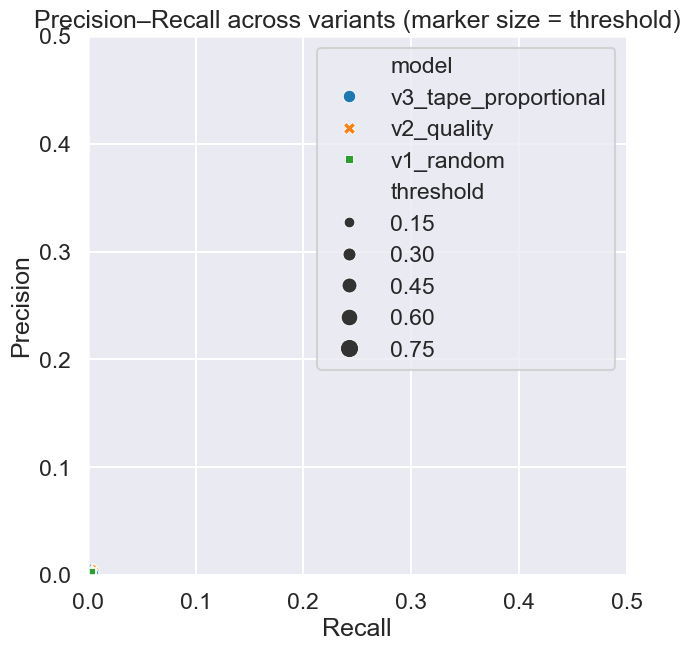

In [42]:
plt.figure(figsize=(7, 7))
ax = sns.scatterplot(
    data=df,
    x="recall",
    y="precision",
    hue="model",
    style="model",
    size="threshold",
    sizes=(50, 200),
)
ax.set(xlim=(0, 0.5), ylim=(0, 0.5), xlabel="Recall", ylabel="Precision")
ax.set_aspect("equal")
plt.title("Precision–Recall across variants (marker size = threshold)")
plt.grid(True)
plt.show()

### Boundary error distributions

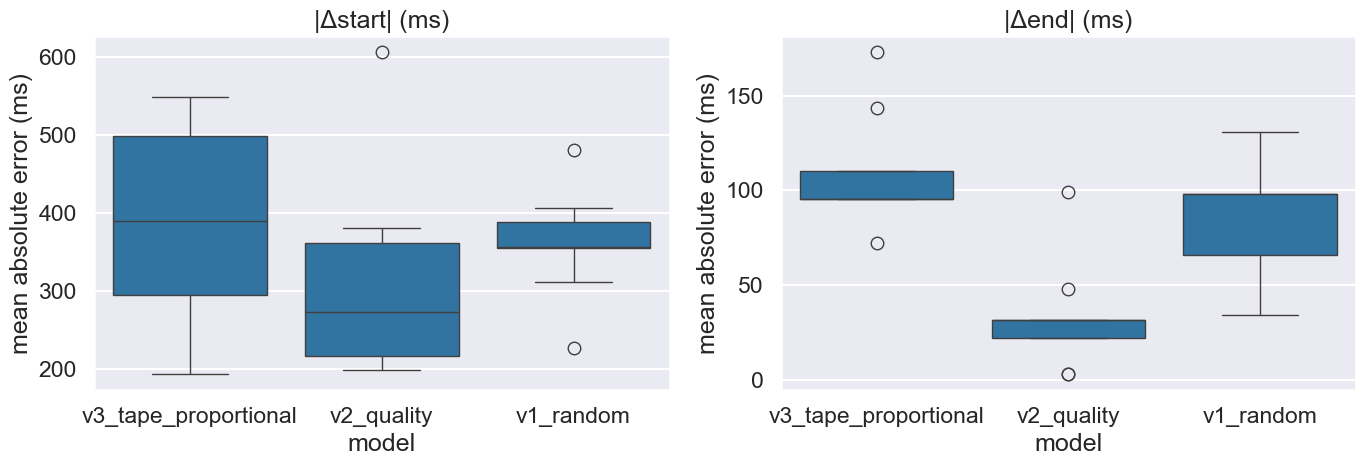

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(x="model", y="mean_dstart_ms", data=df, ax=axs[0])
axs[0].set_title("|Δstart| (ms)")
axs[0].set_ylabel("mean absolute error (ms)")

sns.boxplot(x="model", y="mean_dend_ms", data=df, ax=axs[1])
axs[1].set_title("|Δend| (ms)")
axs[1].set_ylabel("mean absolute error (ms)")

plt.tight_layout()
plt.show()